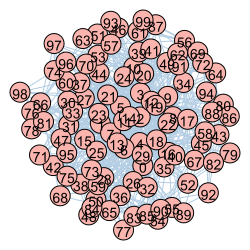

In [111]:
# Load packages
from igraph import *
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Create a tree network using igraph method
G = Graph.Barabasi(n = 100, m = 8, directed = False)


G.vs["name"] = [str(i) for i in range(len(G.vs))]

#transforming to dataframe
g = pd.DataFrame({'source': [x for e in G.es for x in (e.source, e.target)],
                  'target': [x for e in G.es for x in (e.target, e.source)]})
#plotting
p_style = {"bbox": (250, 250), "vertex_color": "#FBB4AE", "edge_color": "#B3CDE3"}
plot(G, layout=G.layout("kk"), vertex_label=G.vs["name"], **p_style)

In [112]:
# Parameters
# Transmission rate
beta = 0.5  
# Recovery rate
gamma = 0.5
#Time 
T = 5
#Initial probability for infected node
p0 = pd.DataFrame({'node': g['source'].unique(), 'prob': 0})
p0.loc[p0['node'].isin([1]), 'prob'] = 0.6

In [113]:
import numpy as np
from scipy.integrate import quad
from scipy.optimize import fsolve

def degree_distributionk(network):
    """
    Calculate the degree distribution of the network.
    """
    degrees = pd.concat([network['source'], network['target']]).value_counts()
    max_degree = max(degrees)
    # Count the unique nodes in the network
    num_nodes = len(pd.concat([network['source'], network['target']]).unique())
    pk = np.bincount(degrees, minlength=max_degree+1) / float(num_nodes)
    return pk

def degree_distribution(graph):
    degrees = graph.degree()
    max_degree = max(degrees)
    num_nodes = len(degrees)
    pk = np.bincount(degrees, minlength=max_degree+1) / float(num_nodes)
    return pk


def G0(x, pk):
    """
    Generating function for the degree distribution.
    """
    return np.sum(pk * (x ** np.arange(len(pk))))

def outbreak_size_distribution(T, pk):
    """
    Calculate the generating function for the outbreak size distribution.
    """
    def H0(x):
        return G0(1 + T * (x - 1), pk)
    return H0

def critical_transmissibility(pk):
    """
    Calculate the critical transmissibility Tc for the epidemic.
    """
    k = np.arange(len(pk))
    average_degree = np.sum(k * pk)
    if average_degree == 0:
        raise ValueError("The average degree cannot be zero.")
    
    # Calculate the excess degree distribution qk
    qk = (k * pk) / average_degree
    
    # The derivative G1_prime_1 represents the derivative G'_1(1)
    # We are looking for the value of T where T * G1_prime_1 = 1
    def equation(T):
        G1_prime_1 = np.sum(k[1:] * qk[1:])  # We start from k=1 to ignore the term k=0
        return T * G1_prime_1 - 1
    
    Tc, = fsolve(equation, 0.5)
    return Tc


def mean_outbreak_sizet(T, pk):
    """
    Calculate the mean outbreak size for a given transmissibility T.
    """
    H0 = outbreak_size_distribution(T, pk)
    delta = 1e-5
    derivative_at_1 = (H0(1 + delta) - H0(1)) / delta
    return derivative_at_1

from scipy.misc import derivative

def mean_outbreak_size(T, pk):
    """
    Calculate the mean outbreak size for a given transmissibility T.
    """
    H0 = outbreak_size_distribution(T, pk)
    # Using scipy's derivative function to compute the numerical derivative
    derivative_at_1 = derivative(H0, 1.0, dx=1e-6)
    return derivative_at_1

def critical_transmissibilityt(pk):
    """
    Calculate the critical transmissibility Tc for the epidemic.
    """
    # G1_prime_1 represents the derivative G'_1(1)
    # We are looking for the value of T where T * G1_prime_1 = 1
    def equation(T, pk):
        k = np.arange(len(pk))
        G1_prime_1 = np.sum(k * (k - 1) * pk) / np.sum(k * pk)
        return T * G1_prime_1 - 1

    Tc, = fsolve(equation, 1, args=(pk))
    return Tc


# Example usage
# You need to provide the 'network' variable which should be a NetworkX graph object
pk = degree_distribution(G)
#pkj = degree_distributionk(g)
print(pk)
#print(pkj)
Tc = critical_transmissibility(pk)
print(f"Critical transmissibility: {Tc}")
mean_size = mean_outbreak_size(beta, pk)
print(f"Mean outbreak size at critical transmissibility: {mean_size}")


[0.   0.   0.   0.   0.   0.   0.   0.   0.18 0.15 0.07 0.12 0.09 0.02
 0.02 0.04 0.02 0.02 0.   0.01 0.03 0.02 0.   0.01 0.03 0.02 0.01 0.01
 0.02 0.02 0.   0.01 0.   0.01 0.02 0.01 0.   0.01 0.   0.01 0.01 0.
 0.   0.01]
Critical transmissibility: 0.04918560484130561
Mean outbreak size at critical transmissibility: 7.640000001085667


In [116]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from igraph import Graph

def degree_distribution(graph):
    degrees = graph.degree()
    max_degree = max(degrees)
    num_nodes = len(degrees)
    pk = np.bincount(degrees, minlength=max_degree+1) / float(num_nodes)
    return pk

def G0(x, T, pk):
    k = np.arange(len(pk))
    return np.sum(pk * ((1 - T + x * T) ** k))

def find_u(T, pk, initial_guess=0.5):
    # Define the function for the self-consistency relation u = G1(u; T)
    def self_consistency(u):
        k = np.arange(1, len(pk))
        qk = k * pk[k] / np.sum(k * pk[k])  # Excess degree distribution
        return u - np.sum(qk * ((1 - T + u * T) ** (k - 1)))

    # Solve for u using a numerical solver
    u, = fsolve(self_consistency, initial_guess)
    return u

def S(T, pk):
    u = find_u(T, pk)
    return 1 - G0(u, T, pk)

# Create a Barabási-Albert network using igraph
G = Graph.Barabasi(n=10, m=2, directed=False)

# Calculate the degree distribution
pk = degree_distribution(G)


S_valuess = S(beta, pk)




In [117]:
S_valuess

0.6718621867535084

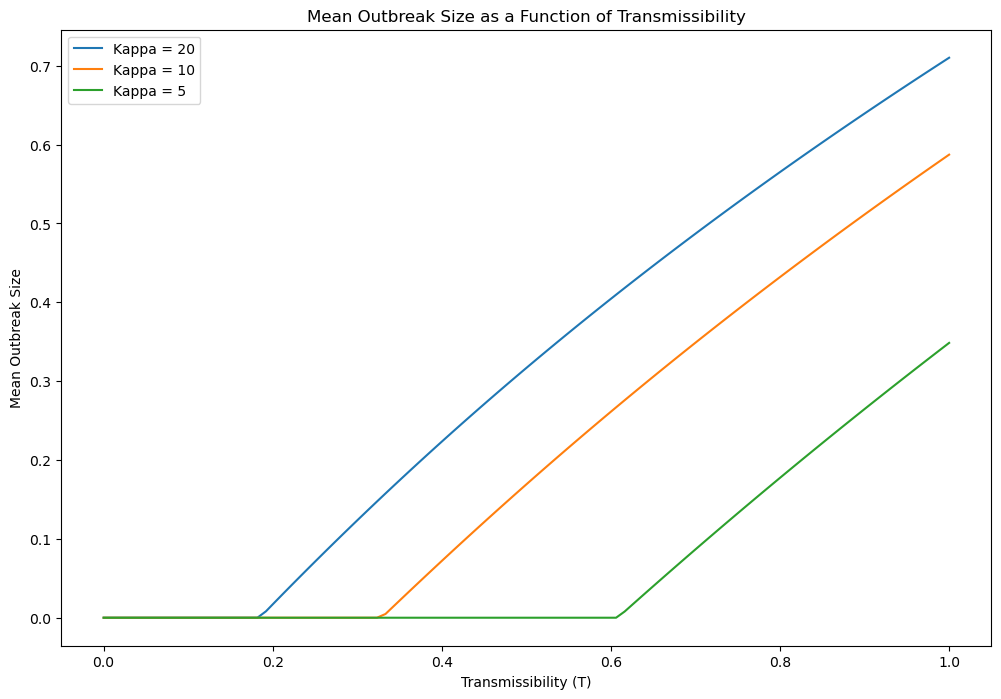

In [82]:
import numpy as np
from scipy.special import zeta
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

import mpmath

def degree_distribution(k, alpha, kappa):
    if k < 1:
        return 0
    normalization = mpmath.polylog(alpha, np.exp(-1/kappa))
    normalization = float(normalization)
    return (k**-alpha * np.exp(-k/kappa)) / normalization


def generate_pk(alpha, kappa, max_k=100):
    pk = np.array([degree_distribution(k, alpha, kappa) for k in range(max_k+1)])
    return pk

def G0(x, T, pk):
    k = np.arange(len(pk))
    return np.sum(pk * ((1 - T + x * T) ** k))

def find_u(T, pk, initial_guess=0.5):
    def self_consistency(u):
        k = np.arange(1, len(pk)) 
        qk = k * pk[k] / np.sum(k * pk[k])  # Excess degree distribution
        return u - np.sum(qk * ((1 - T + u * T) ** (k - 1)))
    u, = fsolve(self_consistency, initial_guess)
    return u

def S(T, pk):
    u = find_u(T, pk)
    return 1 - G0(u, T, pk)

# Parameters from the paper for the degree distribution
alpha = 2
kappas = [20, 10, 5]

# Range of transmissibility values
T_values = np.linspace(0, 1, 100)

# Plotting
plt.figure(figsize=(12, 8))

for kappa in kappas:
    pk = generate_pk(alpha, kappa)
    S_values = [S(T, pk) for T in T_values]
    plt.plot(T_values, S_values, label=f'Kappa = {kappa}')

plt.xlabel('Transmissibility (T)')
plt.ylabel('Mean Outbreak Size')
plt.title('Mean Outbreak Size as a Function of Transmissibility')
plt.legend()
plt.show()
